<a href="https://colab.research.google.com/github/ancientpi3/Fellowship2022/blob/main/olivetti_GAN_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab import drive
from google.colab import files
from zipfile import ZipFile
import cv2
import os

In [3]:
drive.mount('/content/gdrive')
filename = "/content/gdrive/MyDrive/olivetti_faces.npy.zip"

with ZipFile(filename, "r",) as zip:
  zip.extractall(path="/content/face_data")

Mounted at /content/gdrive


In [4]:
x_train = np.load("/content/face_data/olivetti_faces.npy")

In [5]:
x_train.shape

(400, 64, 64)

In [6]:
latent_dim = 300


In [21]:
def discriminator():
  discriminator_input = keras.Input(shape=(64,64,1),name="d_input")
  x = keras.layers.Conv2D(128,(3,3),strides = (2,2),padding = "same", activation="relu")(discriminator_input)
  x = keras.layers.Conv2D(128,(3,3),strides = (2,2),padding = "same", activation="relu")(x)
  x = keras.layers.Conv2D(128,(3,3),strides = (2,2),padding = "same", activation="relu")(x)
  x = keras.layers.Dropout(rate=.3)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(50)(x)
  x = keras.layers.Dropout(rate=.3)(x)
  discriminator_output = keras.layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(discriminator_input, discriminator_output,name="discriminator")
  opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [20]:
def generator(latent_dim=latent_dim):
  generator_input = keras.Input(shape=(latent_dim),name="g_input")
  n_nodes = 8*8*128
  x = keras.layers.Dense(50)(generator_input)
  x = keras.layers.Dropout(rate=.3)(x)
  x = keras.layers.Dense(n_nodes)(x)
  x = keras.layers.Reshape((8,8,128))(x)
  x = keras.layers.Dropout(rate=.3)(x)
  x = keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',activation="relu")(x)
  x = keras.layers.Dropout(rate=.3)(x)
  x = keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',activation="relu")(x)
  x = keras.layers.Dropout(rate=.3)(x)
  x = keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',activation="relu")(x)
  generator_output = keras.layers.Conv2D(1,(7,7),padding="same",activation="sigmoid")(x)
  return keras.Model(generator_input, generator_output,name="generator")

In [18]:
d_model = discriminator()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d_input (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       1280      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 50)              

In [19]:
g_model = generator()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 g_input (InputLayer)        [(None, 300)]             0         
                                                                 
 dense_6 (Dense)             (None, 50)                15050     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 8192)              417792    
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      14

In [11]:
def GAN(d_model,g_model):
	d_model.trainable = False
	model = keras.models.Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [12]:
GAN_model = GAN(d_model,g_model)
GAN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Functional)      (None, 64, 64, 1)         2155817   
                                                                 
 discriminator (Functional)  (None, 1)                 706149    
                                                                 
Total params: 2,861,966
Trainable params: 2,155,817
Non-trainable params: 706,149
_________________________________________________________________


In [13]:
def grab_real_batch(x_train, batch_size):
	ix = np.random.randint(0, x_train.shape[0], batch_size)
	X = x_train[ix]
	#y = np.ones((batch_size, 1))
	return X

In [14]:
def grab_fake_batch(g_model,batch_size, latent_dim=latent_dim):
  latent_points = np.random.randn(latent_dim*batch_size).reshape(batch_size,latent_dim)
  predictions = g_model.predict(latent_points,verbose=0)
  return predictions

In [31]:
def save_plot(examples, epoch, n=5):
	for i in range(25):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray')
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.show()
	plt.savefig(filename)
	plt.close()

In [29]:
def train(d_model,g_model,gan_model, x_train, epochs=200, verbose=1):
  latent_dim = g_model.input.shape[1]
  batch_size = 32
  batches_per_epoch = 50
  save_plot(grab_fake_batch(g_model,50).reshape(50,64,64,1),epoch=0)
  for epoch in range(epochs):
    print("Epoch: ",epoch)
    for _ in range(batches_per_epoch):
      d_model.trainable = True
      #print("training discriminator on real batch")
      real_batch = grab_real_batch(x_train, batch_size)
      d_model.fit(x=real_batch, y = np.ones(batch_size),verbose=verbose)
      #print("training discriminator on fake batch")
      fake_batch = grab_fake_batch(g_model, batch_size)
      d_model.fit(x=fake_batch, y = np.zeros(batch_size),verbose=verbose)

      d_model.trainable = False
      #print("training GAN on fake batch with real label to measure how well G fools D")
      latent_points = np.random.randn(latent_dim*batch_size).reshape(batch_size,latent_dim)
      gan_model.fit(x=latent_points, y=np.ones(batch_size),verbose=verbose)
    if(epoch%20==19):
      save_plot(grab_fake_batch(g_model,50).reshape(50,64,64,1),epoch=epoch)

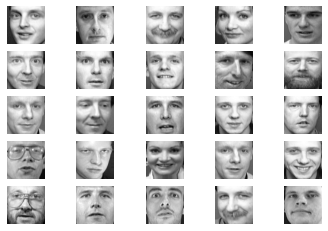

In [32]:
save_plot(grab_real_batch(x_train,40).reshape(40,64,64,1),epoch=-1)

In [33]:
train(d_model,g_model, GAN_model,x_train, verbose=0)

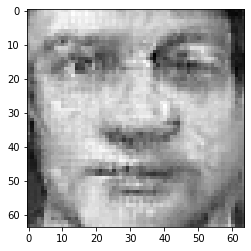

In [ ]:
results = grab_fake_batch(g_model,5)
plt.imshow(results[0].reshape(64,64), cmap="gray")

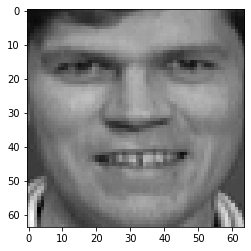

In [ ]:
results = grab_real_batch(x_train,5)
plt.imshow(results[0].reshape(64,64), cmap="gray")

In [ ]:
g_model.save("olivetti_g_model_v3.h5")